In [55]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import (Dense, LSTM, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, Layer, 
                        Bidirectional, MultiHeadAttention, LayerNormalization, Lambda)
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

from datetime import datetime, timedelta, time

import random

In [56]:
import yfinance as yf

# Fetch Bitcoin data
data = yf.download('BTC-USD', start='2014-01-01', end=pd.Timestamp.today())

data = data.reset_index()  # Make Date a regular column
data.columns = data.columns.droplevel(1)  # Remove the Ticker level from column
data = data.rename(columns={'Close':'price', 'Date':'date', 'Volume':'volume'})  # Rename Price
btc_original = data.copy()

print(data[-1:])

[*********************100%***********************]  1 of 1 completed

Price       date          price           High            Low           Open  \
3927  2025-06-18  104883.328125  105581.851562  103602.265625  104602.070312   

Price       volume  
3927   47318089133  


In [57]:
def compute_rsi(series, window=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

def compute_macd(series, slow=26, fast=12, signal=9):
    ema_fast = series.ewm(span=fast).mean()
    ema_slow = series.ewm(span=slow).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal).mean()
    return macd_line - signal_line

In [58]:
# Calculate OBV
def calculate_obv(df):
    obv = [0]
    for i in range(1, len(df)):
        if df['price'].iloc[i] > df['price'].iloc[i-1]:
            obv.append(obv[-1] + df['volume'].iloc[i])
        elif df['price'].iloc[i] < df['price'].iloc[i-1]:
            obv.append(obv[-1] - df['volume'].iloc[i])
        else:
            obv.append(obv[-1])
    df['obv'] = obv
    return df

data = calculate_obv(data)

In [59]:
#Add features
data['rsi'] = compute_rsi(data['price'], window=14)
data['macd'] = compute_macd(data['price'])

#On Balance Volume
#data['obv'] = talib.OBV(data['price'], data['volume'])

#Daily price % increase
data['daily_prt'] = data['price'].pct_change()

data['ma5'] = data['price'].rolling(5).mean()
data['ma5_prt'] = data['ma5'].pct_change()
data.tail(10)

Price,date,price,High,Low,Open,volume,obv,rsi,macd,daily_prt,ma5,ma5_prt
3918,2025-06-09,110294.101562,110561.421875,105400.234375,105793.023438,55903193732,2238574397862,52.097784,-225.714131,0.042540,105533.934375,0.010653
3919,2025-06-10,110257.234375,110380.125000,108367.710938,110295.687500,54700101509,2183874296353,53.166042,22.639055,-0.000334,107270.190625,0.016452
3920,2025-06-11,108686.625000,110384.218750,108086.328125,110261.796875,50842662052,2133031634301,52.176150,64.592009,-0.014245,108129.446875,0.008010
3921,2025-06-12,105929.054688,108780.695312,105785.687500,108685.914062,54843867968,2078187766333,50.686823,-100.918241,-0.025372,108192.132812,0.000580
3922,2025-06-13,106090.968750,106182.546875,102822.023438,105924.593750,69550440846,2147738207179,55.383442,-201.241400,0.001529,108251.596875,0.000550
3923,2025-06-14,105472.406250,106203.757812,104379.367188,106108.085938,38007870453,2109730336726,52.148885,-304.796970,-0.005830,107287.257812,-0.008908
3924,2025-06-15,105552.023438,106157.101562,104519.882812,105464.843750,36744307742,2146474644468,49.729201,-359.699108,0.000755,106346.215625,-0.008771
3925,2025-06-16,106796.757812,108915.375000,104997.625000,105555.593750,50366626945,2196841271413,52.347505,-306.053271,0.011793,105968.242188,-0.003554
3926,2025-06-17,104601.117188,107750.195312,103396.531250,106794.117188,55964092176,2140877179237,48.042974,-406.043009,-0.020559,105702.654688,-0.002506
3927,2025-06-18,104883.328125,105581.851562,103602.265625,104602.070312,47318089133,2188195268370,50.363424,-438.030769,0.002698,105461.126562,-0.002285


In [60]:
data['date'] = data['date'].apply(lambda x : pd.to_datetime(x.date()))

In [61]:
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3915 entries, 13 to 3927
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       3915 non-null   datetime64[ns]
 1   price      3915 non-null   float64       
 2   High       3915 non-null   float64       
 3   Low        3915 non-null   float64       
 4   Open       3915 non-null   float64       
 5   volume     3915 non-null   int64         
 6   obv        3915 non-null   int64         
 7   rsi        3915 non-null   float64       
 8   macd       3915 non-null   float64       
 9   daily_prt  3915 non-null   float64       
 10  ma5        3915 non-null   float64       
 11  ma5_prt    3915 non-null   float64       
dtypes: datetime64[ns](1), float64(9), int64(2)
memory usage: 397.6 KB


In [62]:
data.head()

Price,date,price,High,Low,Open,volume,obv,rsi,macd,daily_prt,ma5,ma5_prt
13,2014-09-30,386.944000,390.976990,373.442993,376.088013,34707300,-108228200,31.997433,-2.073979,0.030567,388.707397,-0.012514
14,2014-10-01,383.614990,391.378998,380.779999,387.427002,26229400,-134457600,31.461697,-1.898367,-0.008603,384.545398,-0.010707
15,2014-10-02,375.071991,385.497009,372.946014,383.988007,21777700,-156235300,35.852649,-2.060908,-0.022270,379.655798,-0.012715
16,2014-10-03,359.511993,377.695007,357.859009,375.181000,30901200,-187136500,39.000831,-2.769740,-0.041485,376.121997,-0.009308
17,2014-10-04,328.865997,364.487000,325.885986,359.891998,47236500,-234373000,27.381697,-4.539868,-0.085243,366.801794,-0.024780


In [63]:
import requests
from io import StringIO

#BTC On chain metrics
#source: https://www.blockchain.com/en/explorer

#difficulty
url_diff = 'https://api.blockchain.info/charts/difficulty?timespan=all&rollingAverage=1days&start=2010-01-01&format=json'
url_hash = 'https://api.blockchain.info/charts/hash-rate?timespan=all&rollingAverage=1days&start=2010-01-01&format=json'

def get_chain_metrics(url, column_name):
    response = requests.get(url)
    chain_m = []

    if response.status_code == 200:
        data = response.json()
        chain_m = pd.DataFrame(data['values']).copy()
    
        # Convert and format columns
        chain_m['date'] = pd.to_datetime(chain_m['x'], unit='s')
        chain_m = chain_m[['x', 'y', 'date']] \
             .rename(columns={
                 'x': 'time_sec',
                 'y': column_name
             })
    
        #fill in between values
        # First, set the time_sec as the index to create a complete time series
        chain_m.set_index('time_sec', inplace=True)

        # calculate days to offset (data is often not of the same day as today)
        current_timestamp = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0).timestamp()
        day_offset = int(current_timestamp) - chain_m.index.max()

        # Create a complete index with all seconds in the range (or whatever your interval should be)
        full_index = pd.RangeIndex(start=chain_m.index.min(), stop=chain_m.index.max() + 1, step=86400)  # daily data
        
        # Reindex to create missing values for all time points
        chain_m = chain_m.reindex(full_index)
        
        # Now interpolate the missing values
        chain_m[column_name] = chain_m[column_name].interpolate(method='linear')  # linear interpolation between points
        
        # For the date column, we can forward fill or create proper dates
        # and offset timestep so last entry matches with todays date
        chain_m['date'] = pd.to_datetime(chain_m.index + day_offset, unit='s')
        chain_m['date'] = chain_m['date'].apply(lambda x : pd.to_datetime(x.date()))
        
        # Reset index
        chain_m.reset_index(inplace=True)
        chain_m.rename(columns={'index': 'time_sec'}, inplace=True)
        chain_m = chain_m.drop(columns=['time_sec'])
        
        print(chain_m.head(10))
        return chain_m
        
    else:
        print(f"Error: {response.status_code}")

diff_df = get_chain_metrics(url_diff, 'difficulty')
hash_df = get_chain_metrics(url_hash, 'hash_rate')

print(diff_df.tail())
print(hash_df.tail())

   difficulty       date
0     1.18290 2010-01-05
1     1.18290 2010-01-06
2     1.18290 2010-01-07
3     1.18290 2010-01-08
4     1.18290 2010-01-09
5     1.18290 2010-01-10
6     1.18290 2010-01-11
7     1.18290 2010-01-12
8     1.18290 2010-01-13
9     1.21344 2010-01-14
   hash_rate       date
0   0.000008 2010-01-05
1   0.000008 2010-01-06
2   0.000008 2010-01-07
3   0.000009 2010-01-08
4   0.000009 2010-01-09
5   0.000010 2010-01-10
6   0.000010 2010-01-11
7   0.000011 2010-01-12
8   0.000011 2010-01-13
9   0.000011 2010-01-14
        difficulty       date
5640  1.269823e+14 2025-06-15
5641  1.268396e+14 2025-06-16
5642  1.266969e+14 2025-06-17
5643  1.265541e+14 2025-06-18
5644  1.264114e+14 2025-06-19
         hash_rate       date
5640  9.342239e+08 2025-06-15
5641  9.300320e+08 2025-06-16
5642  9.258401e+08 2025-06-17
5643  9.216481e+08 2025-06-18
5644  9.174562e+08 2025-06-19


In [64]:
#merge on chain metrics
data = data.merge(diff_df, on='date', how='outer')  #merge
data = data.merge(hash_df, on='date', how='outer')  #merge

In [65]:
data.tail(10)

,date,price,High,Low,Open,volume,obv,rsi,macd,daily_prt,ma5,ma5_prt,difficulty,hash_rate
5635,2025-06-10,110257.234375,110380.125000,108367.710938,110295.687500,5.470010e+10,2.183874e+12,53.166042,22.639055,-0.000334,107270.190625,0.016452,1.269823e+14,9.231773e+08
5636,2025-06-11,108686.625000,110384.218750,108086.328125,110261.796875,5.084266e+10,2.133032e+12,52.176150,64.592009,-0.014245,108129.446875,0.008010,1.269823e+14,9.657855e+08
5637,2025-06-12,105929.054688,108780.695312,105785.687500,108685.914062,5.484387e+10,2.078188e+12,50.686823,-100.918241,-0.025372,108192.132812,0.000580,1.269823e+14,9.578951e+08
5638,2025-06-13,106090.968750,106182.546875,102822.023438,105924.593750,6.955044e+10,2.147738e+12,55.383442,-201.241400,0.001529,108251.596875,0.000550,1.269823e+14,9.500047e+08
5639,2025-06-14,105472.406250,106203.757812,104379.367188,106108.085938,3.800787e+10,2.109730e+12,52.148885,-304.796970,-0.005830,107287.257812,-0.008908,1.269823e+14,9.421143e+08
5640,2025-06-15,105552.023438,106157.101562,104519.882812,105464.843750,3.674431e+10,2.146475e+12,49.729201,-359.699108,0.000755,106346.215625,-0.008771,1.269823e+14,9.342239e+08
5641,2025-06-16,106796.757812,108915.375000,104997.625000,105555.593750,5.036663e+10,2.196841e+12,52.347505,-306.053271,0.011793,105968.242188,-0.003554,1.268396e+14,9.300320e+08
5642,2025-06-17,104601.117188,107750.195312,103396.531250,106794.117188,5.596409e+10,2.140877e+12,48.042974,-406.043009,-0.020559,105702.654688,-0.002506,1.266969e+14,9.258401e+08
5643,2025-06-18,104883.328125,105581.851562,103602.265625,104602.070312,4.731809e+10,2.188195e+12,50.363424,-438.030769,0.002698,105461.126562,-0.002285,1.265541e+14,9.216481e+08
5644,2025-06-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.264114e+14,9.174562e+08


In [66]:
data = data.dropna()
data.tail()

,date,price,High,Low,Open,volume,obv,rsi,macd,daily_prt,ma5,ma5_prt,difficulty,hash_rate
5639,2025-06-14,105472.406250,106203.757812,104379.367188,106108.085938,3.800787e+10,2.109730e+12,52.148885,-304.796970,-0.005830,107287.257812,-0.008908,1.269823e+14,9.421143e+08
5640,2025-06-15,105552.023438,106157.101562,104519.882812,105464.843750,3.674431e+10,2.146475e+12,49.729201,-359.699108,0.000755,106346.215625,-0.008771,1.269823e+14,9.342239e+08
5641,2025-06-16,106796.757812,108915.375000,104997.625000,105555.593750,5.036663e+10,2.196841e+12,52.347505,-306.053271,0.011793,105968.242188,-0.003554,1.268396e+14,9.300320e+08
5642,2025-06-17,104601.117188,107750.195312,103396.531250,106794.117188,5.596409e+10,2.140877e+12,48.042974,-406.043009,-0.020559,105702.654688,-0.002506,1.266969e+14,9.258401e+08
5643,2025-06-18,104883.328125,105581.851562,103602.265625,104602.070312,4.731809e+10,2.188195e+12,50.363424,-438.030769,0.002698,105461.126562,-0.002285,1.265541e+14,9.216481e+08


In [67]:
#Fear and Greed Index data
import requests
from io import StringIO

#source: https://alternative.me/crypto/fear-and-greed-index/
url = 'https://api.alternative.me/fng/?limit=0'
response = requests.get(url)

if response.status_code == 200:
    data_r = response.json()
    df_response = pd.DataFrame(data_r['data'])

    # Convert and format columns
    df_response['date'] = pd.to_datetime(df_response['timestamp'], unit='s')
    df_response = df_response[['value', 'value_classification', 'date']] \
         .rename(columns={
             'value': 'fng_value',
             'value_classification': 'classification'
         })
    
    print(df_response.head(10))
    
else:
    print(f"Error: {response.status_code}")

  fng_value classification       date
0        57          Greed 2025-06-19
1        52        Neutral 2025-06-18
2        68          Greed 2025-06-17
3        61          Greed 2025-06-16
4        60          Greed 2025-06-15
5        63          Greed 2025-06-14
6        61          Greed 2025-06-13
7        71          Greed 2025-06-12
8        72          Greed 2025-06-11
9        71          Greed 2025-06-10


C:\Users\joseh\AppData\Local\Temp\ipykernel_18364\2732264801.py:14: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df_response['date'] = pd.to_datetime(df_response['timestamp'], unit='s')


In [68]:
df_response['fng_value'] = df_response['fng_value'].apply(lambda x: float(x))
fng_df = df_response.copy()
fng_df.tail(10)

,fng_value,classification,date
2682,54.0,Neutral,2018-02-10
2683,44.0,Fear,2018-02-09
2684,30.0,Fear,2018-02-08
2685,36.0,Fear,2018-02-07
2686,8.0,Extreme Fear,2018-02-06
2687,11.0,Extreme Fear,2018-02-05
2688,24.0,Extreme Fear,2018-02-04
2689,40.0,Fear,2018-02-03
2690,15.0,Extreme Fear,2018-02-02
2691,30.0,Fear,2018-02-01


In [69]:
data_2018 = data.merge(fng_df, on='date', how='outer')  #merge
data_2018.head()

,date,price,High,Low,Open,volume,obv,rsi,macd,daily_prt,ma5,ma5_prt,difficulty,hash_rate,fng_value,classification
0,2014-09-30,386.944000,390.976990,373.442993,376.088013,34707300.0,-108228200.0,31.997433,-2.073979,0.030567,388.707397,-0.012514,3.466143e+10,260608.110300,NaN,NaN
1,2014-10-01,383.614990,391.378998,380.779999,387.427002,26229400.0,-134457600.0,31.461697,-1.898367,-0.008603,384.545398,-0.010707,3.466143e+10,261038.867507,NaN,NaN
2,2014-10-02,375.071991,385.497009,372.946014,383.988007,21777700.0,-156235300.0,35.852649,-2.060908,-0.022270,379.655798,-0.012715,3.466143e+10,261469.624714,NaN,NaN
3,2014-10-03,359.511993,377.695007,357.859009,375.181000,30901200.0,-187136500.0,39.000831,-2.769740,-0.041485,376.121997,-0.009308,3.466143e+10,261900.381921,NaN,NaN
4,2014-10-04,328.865997,364.487000,325.885986,359.891998,47236500.0,-234373000.0,27.381697,-4.539868,-0.085243,366.801794,-0.024780,3.466143e+10,258023.567057,NaN,NaN


In [70]:
data_2018 = data_2018.dropna()
data_2018.head()

,date,price,High,Low,Open,volume,obv,rsi,macd,daily_prt,ma5,ma5_prt,difficulty,hash_rate,fng_value,classification
1220,2018-02-01,9170.540039,10288.799805,8812.280273,10237.299805,9.959400e+09,1.237985e+11,34.828472,-129.294851,-0.102783,10516.127930,-0.041388,2.603077e+12,2.050985e+07,30.0,Fear
1221,2018-02-02,8830.750000,9142.280273,7796.490234,9142.280273,1.272690e+10,1.110716e+11,32.204720,-177.439771,-0.037052,9925.017969,-0.056210,2.603077e+12,2.057455e+07,15.0,Extreme Fear
1222,2018-02-03,9174.910156,9430.750000,8251.629883,8852.120117,7.263790e+09,1.183354e+11,22.831301,-167.655576,0.038973,9500.719922,-0.042750,2.603077e+12,2.063925e+07,40.0,Fear
1223,2018-02-04,8277.009766,9334.870117,8031.220215,9175.700195,7.073550e+09,1.112618e+11,24.250826,-200.958719,-0.097865,9134.861914,-0.038508,2.603077e+12,2.070395e+07,24.0,Extreme Fear
1224,2018-02-05,6955.270020,8364.839844,6756.680176,8270.540039,9.285290e+09,1.019765e+11,22.022131,-286.112778,-0.159688,8481.695996,-0.071503,2.603077e+12,2.151270e+07,11.0,Extreme Fear


In [71]:
#Change main data
data = data_2018.copy()

In [72]:
data.tail()

,date,price,High,Low,Open,volume,obv,rsi,macd,daily_prt,ma5,ma5_prt,difficulty,hash_rate,fng_value,classification
3910,2025-06-14,105472.406250,106203.757812,104379.367188,106108.085938,3.800787e+10,2.109730e+12,52.148885,-304.796970,-0.005830,107287.257812,-0.008908,1.269823e+14,9.421143e+08,63.0,Greed
3911,2025-06-15,105552.023438,106157.101562,104519.882812,105464.843750,3.674431e+10,2.146475e+12,49.729201,-359.699108,0.000755,106346.215625,-0.008771,1.269823e+14,9.342239e+08,60.0,Greed
3912,2025-06-16,106796.757812,108915.375000,104997.625000,105555.593750,5.036663e+10,2.196841e+12,52.347505,-306.053271,0.011793,105968.242188,-0.003554,1.268396e+14,9.300320e+08,61.0,Greed
3913,2025-06-17,104601.117188,107750.195312,103396.531250,106794.117188,5.596409e+10,2.140877e+12,48.042974,-406.043009,-0.020559,105702.654688,-0.002506,1.266969e+14,9.258401e+08,68.0,Greed
3914,2025-06-18,104883.328125,105581.851562,103602.265625,104602.070312,4.731809e+10,2.188195e+12,50.363424,-438.030769,0.002698,105461.126562,-0.002285,1.265541e+14,9.216481e+08,52.0,Neutral


In [73]:
features = ['price', 'rsi', 'macd', 'volume', 'obv', 'fng_value', 
            'daily_prt', 
            'difficulty', 'hash_rate',
            'ma5',
            'ma5_prt']
target = 'ma5_prt'

# Prepare data for time series prediction
# Normalize each feature separately
filtered_data = data[features].values

scalers = {}
for i in range(len(features)):
    scaler = MinMaxScaler(feature_range=(0, 1))
    filtered_data[:, i:i+1] = scaler.fit_transform(filtered_data[:, i:i+1])
    scalers[features[i]] = scaler

target_index = features.index(target)

#look_back = 70
look_back = 50
X, y = [], []
for i in range(look_back, len(data)):
    X.append(filtered_data[i-look_back:i, :])
    y.append(filtered_data[i, target_index])

X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], len(features)))

print(X.shape)
print(y.shape)

(2641, 50, 11)
(2641,)


In [74]:
filtered_data.shape

(2691, 11)

In [75]:
import keras

keras.utils.set_random_seed(114)

In [76]:

# Create CNN-LSTM model
model = Sequential()

# CNN layers
model.add(Conv1D(filters=256, kernel_size=2, activation='relu', input_shape=(look_back, len(features))))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=256, kernel_size=1, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# LSTM layers
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=50))
model.add(Dropout(0.2))

# Attention layer
model.add(Dense(units=100, activation='tanh'))
model.add(Dropout(0.3))

# Dense layers
model.add(Dense(units=50, activation='relu'))
model.add(Dense(units=1))

model.compile(optimizer=Adam(learning_rate=0.003), loss='mean_squared_error')


C:\Users\joseh\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [77]:
# Main execution
test_size = 0.05  # Percentage of data to use for testing
#test_size = len(X) - look_back -1

# Split into train and test sets
split = int(len(X) * (1 - test_size))
#split = int(len(X) -1)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [78]:
epochs = 228
batch_size = 32

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False, verbose=1)

# Create and train model
history = model.fit(X_train, y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    validation_data=(X_test, y_test),
                    #callbacks=[early_stop],
                    verbose=1)

Epoch 1/228
79/79 ━━━━━━━━━━━━━━━━━━━━ 21s 73ms/step - loss: 0.0838 - val_loss: 0.0049
Epoch 2/228
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 0.0174 - val_loss: 0.0089
Epoch 3/228
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 0.0139 - val_loss: 0.0039
Epoch 4/228
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 0.0112 - val_loss: 0.0039
Epoch 5/228
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 0.0104 - val_loss: 0.0038
Epoch 6/228
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 0.0101 - val_loss: 0.0037
Epoch 7/228
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 0.0092 - val_loss: 0.0035
Epoch 8/228
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 0.0085 - val_loss: 0.0033
Epoch 9/228
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 0.0080 - val_loss: 0.0040
Epoch 10/228
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 0.0079 - val_loss: 0.0033
Epoch 11/228
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0075 - val_loss: 0.0033
Epoch 12/228
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/ste

In [79]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

print(f"y_test shape: {y_test.shape}")  # Should be (n_samples,)
print(f"Predictions shape: {test_predict.shape}")  # Should match y_test

79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
y_test shape: (133,)
Predictions shape: (133, 1)


In [80]:
def inverse_scaler(scaled_data, features, scalers):
    ### Inverse transform
    dummy_array = np.zeros((len(scaled_data), len(features)))
    dummy_array[:, target_index] = scaled_data.flatten()

    for i in range(len(features)):
        dummy_array[:, i] = scalers[features[i]].inverse_transform(dummy_array[:, i].reshape(-1, 1)).flatten()
        scaled_data = dummy_array[:, target_index]
    
    return scaled_data

train_predict = inverse_scaler(train_predict, features, scalers)
test_predict = inverse_scaler(test_predict, features, scalers)
y_train = inverse_scaler(y_train, features, scalers)
y_test = inverse_scaler(y_test, features, scalers)

In [81]:
# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')

Train RMSE: 0.00
Test RMSE: 0.01


In [82]:
# Calculate Pearson Coefficient
r_coef = np.corrcoef(y_train, train_predict)[0, 1]
print(f"Train - Pearson correlation coefficient: {r_coef:.4f}")

r_coef = np.corrcoef(y_test, test_predict)[0, 1]
print(f"Test - Pearson correlation coefficient: {r_coef:.4f}")

Train - Pearson correlation coefficient: 0.9660
Test - Pearson correlation coefficient: 0.5118


In [83]:
print(train_predict[0:10])
print(test_predict[-10:])

[ 0.02076381  0.00246307 -0.01155233 -0.01309819 -0.01658814 -0.01982229
 -0.02850125 -0.0307243  -0.02537534 -0.01922175]
[ 0.00223859  0.00856661  0.0160653   0.01535301  0.01009827 -0.00673542
 -0.00489114 -0.00421622  0.00214946  0.01575865]


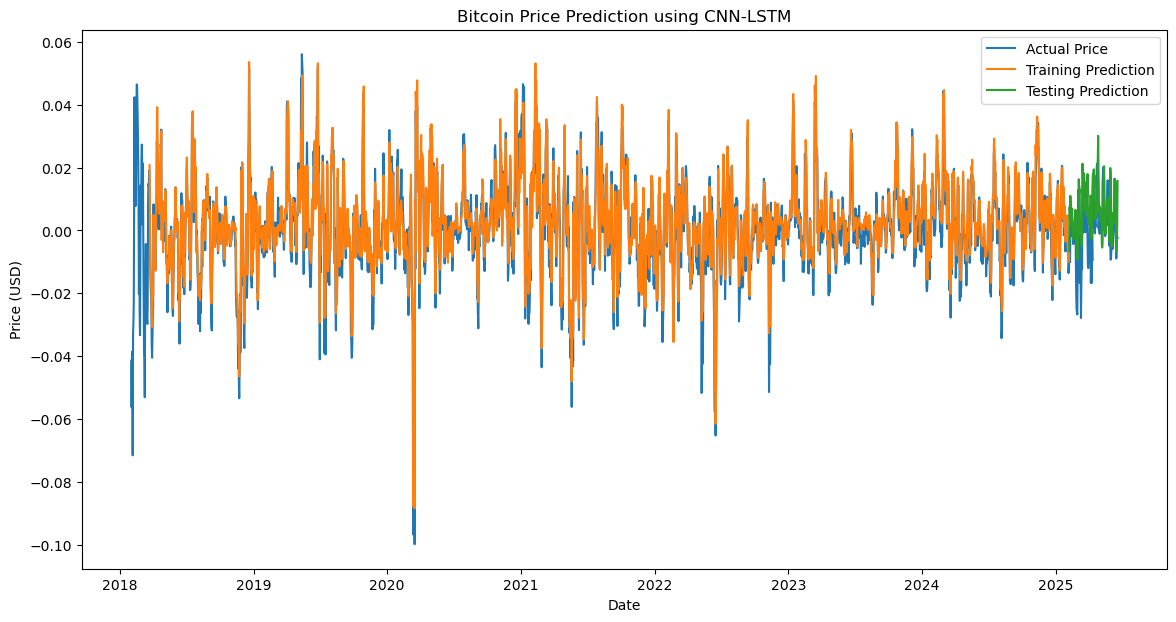

In [84]:
import matplotlib.pyplot as plt

# Plot results
plt.figure(figsize=(14, 7))

# Plot baseline and predictions
plt.plot(data['date'], data[target], label='Actual Price')
plt.plot(data[look_back:split + look_back]['date'], train_predict, label='Training Prediction')
plt.plot(data[split + look_back:]['date'], test_predict, label='Testing Prediction')
plt.title('Bitcoin Price Prediction using CNN-LSTM')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

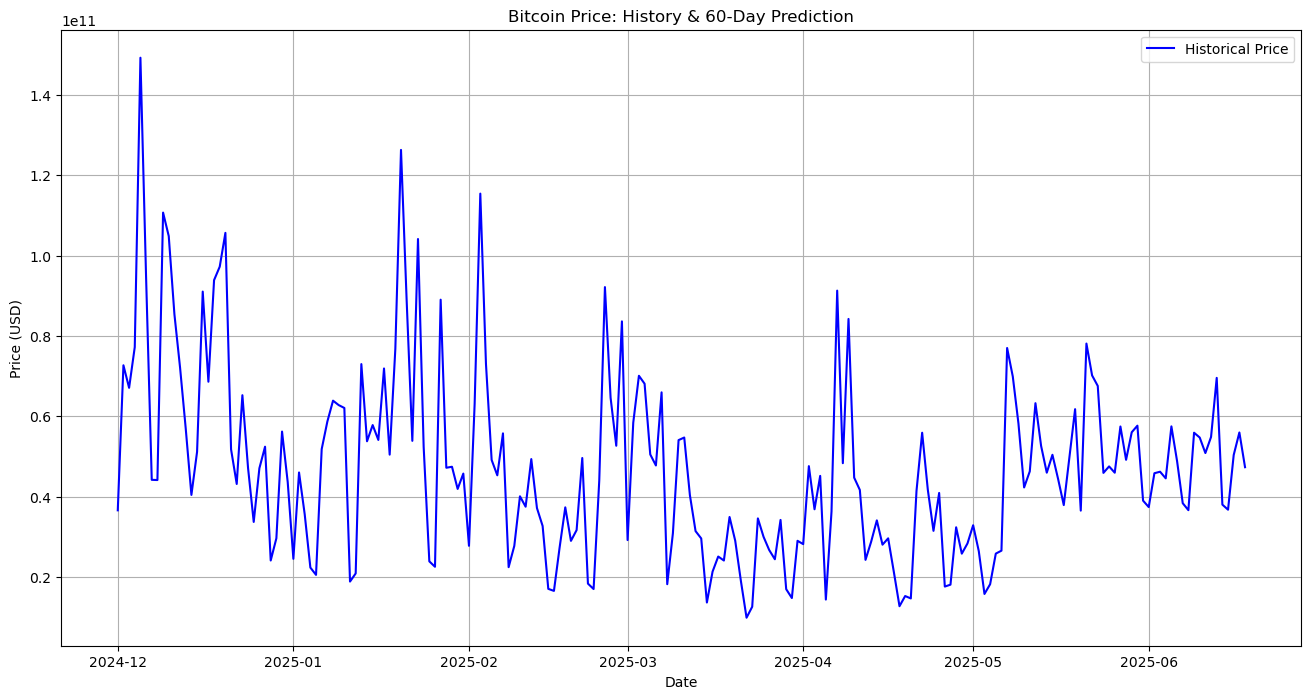

In [85]:
# Plot results
plt.figure(figsize=(16, 8))

# Plot historical data
plt.plot(data['date'][-200:], data['volume'][-200:], label='Historical Price', color='blue')  # Last 500 days

# Formatting
plt.title('Bitcoin Price: History & 60-Day Prediction')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [86]:
data.tail()

,date,price,High,Low,Open,volume,obv,rsi,macd,daily_prt,ma5,ma5_prt,difficulty,hash_rate,fng_value,classification
3910,2025-06-14,105472.406250,106203.757812,104379.367188,106108.085938,3.800787e+10,2.109730e+12,52.148885,-304.796970,-0.005830,107287.257812,-0.008908,1.269823e+14,9.421143e+08,63.0,Greed
3911,2025-06-15,105552.023438,106157.101562,104519.882812,105464.843750,3.674431e+10,2.146475e+12,49.729201,-359.699108,0.000755,106346.215625,-0.008771,1.269823e+14,9.342239e+08,60.0,Greed
3912,2025-06-16,106796.757812,108915.375000,104997.625000,105555.593750,5.036663e+10,2.196841e+12,52.347505,-306.053271,0.011793,105968.242188,-0.003554,1.268396e+14,9.300320e+08,61.0,Greed
3913,2025-06-17,104601.117188,107750.195312,103396.531250,106794.117188,5.596409e+10,2.140877e+12,48.042974,-406.043009,-0.020559,105702.654688,-0.002506,1.266969e+14,9.258401e+08,68.0,Greed
3914,2025-06-18,104883.328125,105581.851562,103602.265625,104602.070312,4.731809e+10,2.188195e+12,50.363424,-438.030769,0.002698,105461.126562,-0.002285,1.265541e+14,9.216481e+08,52.0,Neutral


In [87]:
data_future = data.copy()

In [88]:
print(features)
print(len(features))

['price', 'rsi', 'macd', 'volume', 'obv', 'fng_value', 'daily_prt', 'difficulty', 'hash_rate', 'ma5', 'ma5_prt']
11


In [89]:
# Prepare last sequence
last_sequence = data.iloc[-look_back:].copy()
scaled_sequence = last_sequence.copy()

# Scale each feature
for i, column in enumerate(features):
    scaled_sequence[column] = scalers[column].transform(last_sequence[column].values.reshape(-1, 1))

predictions = []
current_sequence = scaled_sequence[features].values.copy()

days_to_predict = 60

for i in range(days_to_predict):
    # Reshape for prediction
    x_input = current_sequence.reshape((1, look_back, len(features)))
    
    # Make prediction
    predicted_price_scaled = model.predict(x_input, verbose=1)
    
    # Create new row with predicted close and forecasted indicators
    new_row = current_sequence[-1].copy()
    new_row[0] = predicted_price_scaled[0, 0]  # Update price
    
    # Inverse transform just the price
    predicted_price = scalers[target].inverse_transform(predicted_price_scaled)[0, 0]
    last_price = data_future.loc[data_future.index[-1], 'price']
    predictions.append((1 + predicted_price) * last_price)

    #Add price to data
    predicted_row = {'price': (1 + predicted_price) * last_price, 
                     'rsi': 0, 'macd': 0, 'volume': 0, 'obv': 0, 
                     'fng_value': 0, 'difficulty': 0, 'hash_rate': 0,
                     'ma5': 0, 
                     'daily_prt': predicted_price}
    data_future.loc[len(data_future)] = predicted_row

    #Recalculate metrics
    data_future['rsi'] = compute_rsi(data_future['price'], window=14)
    data_future['macd'] = compute_macd(data_future['price'])

    #Volume
    data_future.loc[data_future.index[-1], 'volume'] = data_future['volume'].iloc[-1 + i] * random.uniform(-.02, 0.04)
    
    #On Balance Volume
    data_future = calculate_obv(data_future)
    #data_future['obv'] = talib.OBV(data_future['price'], data_future['volume'])

    #Fear and Greed
    data_future.loc[data_future.index[-1], 'fng_value'] = data_future['fng_value'].rolling(window=7).mean().iloc[-1]

    #Difficulty
    data_future.loc[data_future.index[-1], 'difficulty'] = data_future['difficulty'].iloc[-2] * 1.006

    #Hash Rate
    data_future.loc[data_future.index[-1], 'hash_rate'] = data_future['hash_rate'].iloc[-2]

    #Moving Average 3days
    data_future.loc[data_future.index[-1], 'ma5'] = data_future['price'].rolling(window=7).mean().iloc[-1]

    #Daily Pcrt Gain
    #data_future.loc[data_future.index[-1], 'daily_prt'] = data_future['hash_rate'].iloc[-2]

    #Scale last entry and add to new row sequence
    new_row[1] = scalers['rsi'].transform([[data_future.loc[data_future.index[-1], 'rsi']]])[0][0] #RSI
    new_row[2] = scalers['macd'].transform([[data_future.loc[data_future.index[-1], 'macd']]])[0][0]  #MACD
    new_row[3] = scalers['volume'].transform([[data_future.loc[data_future.index[-1], 'volume']]])[0][0]  #Volume
    new_row[4] = scalers['obv'].transform([[data_future.loc[data_future.index[-1], 'obv']]])[0][0]  #OBV
    new_row[5] = scalers['fng_value'].transform([[data_future.loc[data_future.index[-1], 'fng_value']]])[0][0]  #FNG
    new_row[6] = scalers['difficulty'].transform([[data_future.loc[data_future.index[-1], 'difficulty']]])[0][0]  #Difficulty
    new_row[7] = scalers['hash_rate'].transform([[data_future.loc[data_future.index[-1], 'hash_rate']]])[0][0]  #Hash Rate
    new_row[6] = scalers['ma5'].transform([[data_future.loc[data_future.index[-1], 'ma5']]])[0][0]  #MA3
    new_row[7] = scalers['daily_prt'].transform([[data_future.loc[data_future.index[-1], 'daily_prt']]])[0][0]  #Daily %

    # Update sequence
    current_sequence = np.vstack([current_sequence[1:], new_row])

# Create dates for predictions
last_date = pd.to_datetime(data.index[-1])  # Convert to pandas Timestamp
prediction_dates = [last_date + pd.Timedelta(days=i) for i in range(1, days_to_predict+1)]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [90]:
#print(future_df.head())
last_date = data['date'][-1:]
#print(data['date'][-1:] + pd.Timedelta(days=3))

#prediction_dates = [last_date + pd.Timedelta(days=i) for i in range(1, days_to_predict+1)]
#print(predictions)

In [91]:
timestamp_day = 86400

In [92]:
last_date_timestamp = pd.to_datetime(last_date.values[0]).timestamp()

#last_date_timestamp + half a day + a day = next day
prediction_dates = [last_date_timestamp + 43200 + 86400 * i for i in range(1, days_to_predict+1)]
print(prediction_dates)

prediction_dates = [datetime.fromtimestamp(i).date() for i in prediction_dates]
print(prediction_dates)

[1750334400.0, 1750420800.0, 1750507200.0, 1750593600.0, 1750680000.0, 1750766400.0, 1750852800.0, 1750939200.0, 1751025600.0, 1751112000.0, 1751198400.0, 1751284800.0, 1751371200.0, 1751457600.0, 1751544000.0, 1751630400.0, 1751716800.0, 1751803200.0, 1751889600.0, 1751976000.0, 1752062400.0, 1752148800.0, 1752235200.0, 1752321600.0, 1752408000.0, 1752494400.0, 1752580800.0, 1752667200.0, 1752753600.0, 1752840000.0, 1752926400.0, 1753012800.0, 1753099200.0, 1753185600.0, 1753272000.0, 1753358400.0, 1753444800.0, 1753531200.0, 1753617600.0, 1753704000.0, 1753790400.0, 1753876800.0, 1753963200.0, 1754049600.0, 1754136000.0, 1754222400.0, 1754308800.0, 1754395200.0, 1754481600.0, 1754568000.0, 1754654400.0, 1754740800.0, 1754827200.0, 1754913600.0, 1755000000.0, 1755086400.0, 1755172800.0, 1755259200.0, 1755345600.0, 1755432000.0]
[datetime.date(2025, 6, 19), datetime.date(2025, 6, 20), datetime.date(2025, 6, 21), datetime.date(2025, 6, 22), datetime.date(2025, 6, 23), datetime.date(2025

In [93]:
datetime.fromtimestamp(last_date_timestamp)

datetime.datetime(2025, 6, 17, 20, 0)

In [94]:
prediction_dates[0].isoformat()

'2025-06-19'

In [95]:
#datetime.date(prediction_dates[0].values[0])
print(datetime.timestamp(datetime.now()))
print(datetime.timestamp(datetime.now()) % timestamp_day)
print(datetime.timestamp(datetime.now()) - (datetime.timestamp(datetime.now()) % timestamp_day))
print('\n')
print(datetime.timestamp(datetime(2025, 6, 12)))
print(datetime.timestamp(datetime(2025, 6, 13)))
print(datetime.timestamp(datetime(2025, 6, 14)))
print(datetime.timestamp(datetime(2025, 6, 15)))
print('\n')
print(datetime.timestamp(datetime(2025, 6, 15)) - datetime.timestamp(datetime(2025, 6, 14)))

1750341979.996773
50779.99677300453
1750291200.0


1749700800.0
1749787200.0
1749873600.0
1749960000.0


86400.0


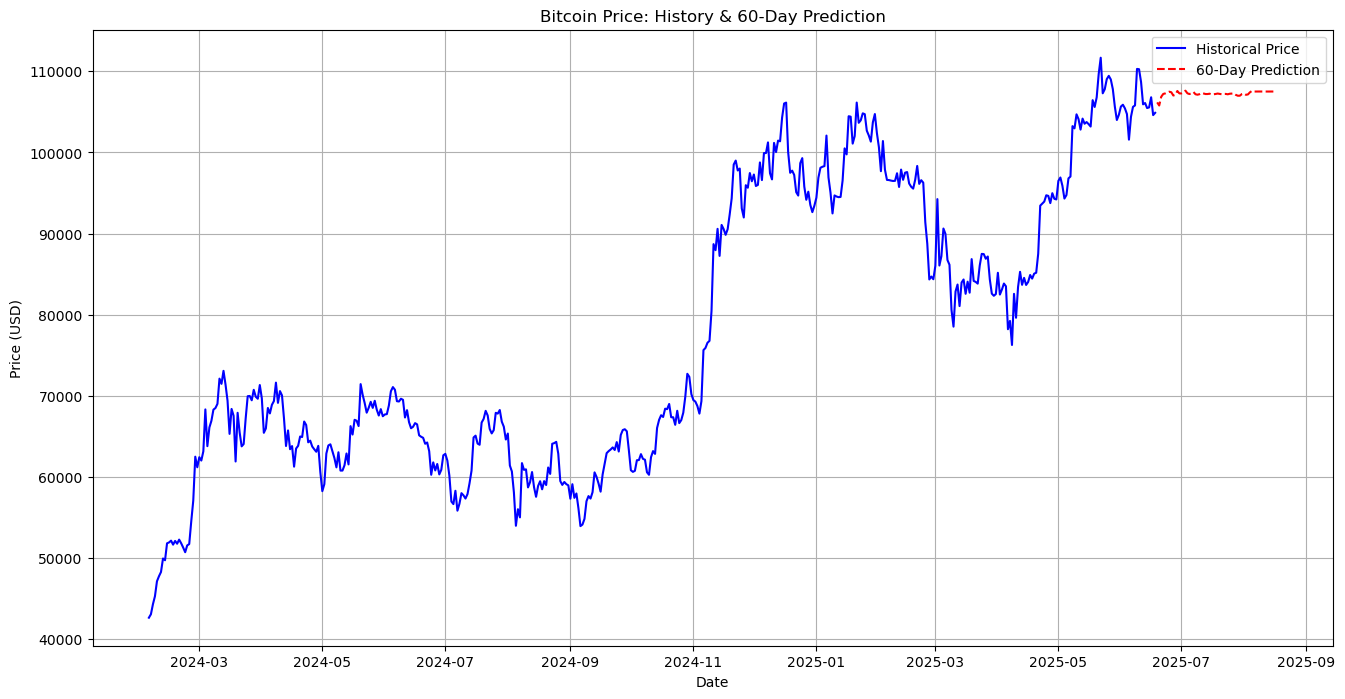


Predicted Bitcoin Prices for the Next 60 Days:
            Predicted_Price
Date                       
2025-06-19    106171.338999
2025-06-20    105784.929759
2025-06-21    106859.484951
2025-06-22    107208.576053
2025-06-23    107277.246413
2025-06-24    107392.832970
2025-06-25    107487.320015
2025-06-26    107416.441105
2025-06-27    107016.433998
2025-06-28    107094.915750


In [96]:
# Create DataFrame for future predictions
future_df = pd.DataFrame({
    'Date': prediction_dates,
    'Predicted_Price': predictions
})
future_df.set_index('Date', inplace=True)

# Plot results
plt.figure(figsize=(16, 8))

# Plot historical data
plt.plot(btc_original['date'][-500:], btc_original['price'][-500:], label='Historical Price', color='blue')  # Last 500 days

# Plot future predictions
plt.plot(prediction_dates, predictions, label=f'{days_to_predict}-Day Prediction', color='red', linestyle='--')

# Formatting
plt.title(f'Bitcoin Price: History & {days_to_predict}-Day Prediction')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# Print the predictions
print("\nPredicted Bitcoin Prices for the Next 60 Days:")
print(future_df.head(10))  # Show first 10 days of prediction

In [97]:
future_df = future_df.reset_index()
future_df

,Date,Predicted_Price
0,2025-06-19,106171.338999
1,2025-06-20,105784.929759
2,2025-06-21,106859.484951
3,2025-06-22,107208.576053
4,2025-06-23,107277.246413
5,2025-06-24,107392.832970
6,2025-06-25,107487.320015
7,2025-06-26,107416.441105
8,2025-06-27,107016.433998
9,2025-06-28,107094.915750


In [98]:
#future_df = future_df.reset_index()
#future_df = future_df.rename(columns={'Date':'date', 'Predicted_price':'price'})  # Rename Price
future_df = future_df[['Date', 'Predicted_Price']]

future_df

,Date,Predicted_Price
0,2025-06-19,106171.338999
1,2025-06-20,105784.929759
2,2025-06-21,106859.484951
3,2025-06-22,107208.576053
4,2025-06-23,107277.246413
5,2025-06-24,107392.832970
6,2025-06-25,107487.320015
7,2025-06-26,107416.441105
8,2025-06-27,107016.433998
9,2025-06-28,107094.915750


In [99]:
future_df.to_csv('lstm_cnn_btc_price.csv', index=False)